# Setup

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm.auto as tqdm
%matplotlib widget

# Phi4 theory

We will use "torch.roll" to compute terms like $\phi_x \phi_{x+\hat{\mu}}$. A little demo:

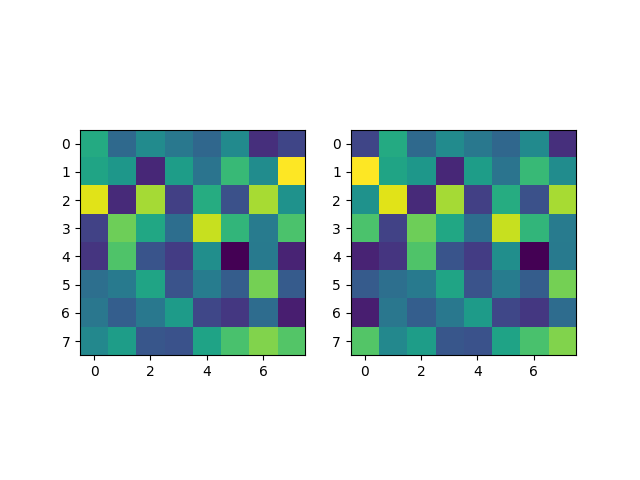

In [2]:
phi = torch.randn((8, 8))
fig, axes = plt.subplots(1,2)
axes[0].imshow(phi)
axes[1].imshow(torch.roll(phi, 1, dims=1))
plt.show()

Lattice action for quartic $\phi^4$ theory, using parameterization in [hep-lat/0506002](http://arxiv.org/abs/hep-lat/0506002)
$$
\begin{aligned}
S(\phi) &= \sum_x \left\{
\frac{m^2}{2} \phi_x^2 + \frac{\lambda}{4!} \phi_x^4 +
\frac{1}{2} \sum_{\mu} \phi_x (2 \phi_x - \phi_{x+\hat{\mu}} - \phi_{x-\hat{\mu}})
\right\} \\
&= \sum_x \left \{
(N_d + \frac{m^2}{2}) \phi_x^2 + \frac{\lambda}{4!} \phi_x^4 - \sum_\mu \phi_x \phi_{x+\hat{\mu}}
\right\}
\end{aligned}
$$

In [3]:
class Phi4Action:
    def __init__(self, m2, lam):
        self.m2 = m2
        self.lam = lam
        self.grad = torch.func.grad(self.value)
    def value(self, phi):
        S = ((2 + self.m2/2)*phi**2 + (self.lam/24)*phi**4).sum()
        for mu in range(2):
            S -= (phi * torch.roll(phi, -1, dims=mu)).sum()
        return S

In [4]:
action = Phi4Action(0.1, 0.01)
print(action.value(phi))
print(action.grad(phi))

tensor(136.1380)
tensor([[  3.4557,  -3.3374,   3.3175,  -0.1115,  -2.0524,   0.2433,  -5.9448,
          -6.7244],
        [ -2.9640,   3.8893,  -8.1471,   4.6458,  -2.6476,   4.5158,  -2.9096,
           9.1479],
        [  9.9163, -10.8006,   9.9915,  -6.7153,   3.0830,  -7.4457,   7.5015,
          -6.0347],
        [ -7.4187,   6.1225,   0.5502,  -1.7462,   6.3327,   4.3604,  -4.0355,
           6.7522],
        [ -3.2063,   5.3306,  -4.2723,  -2.7978,   1.8891,  -7.6601,   1.3695,
          -4.8817],
        [  0.8641,  -1.3897,   4.1510,  -2.8867,   1.6780,  -0.8729,   7.4918,
          -0.8310],
        [  1.4436,  -2.3504,  -0.3897,   4.3432,  -3.5518,  -3.8047,  -1.8101,
          -5.8912],
        [ -1.6962,   3.5097,  -2.6060,  -3.2439,   3.2885,   3.4248,   5.4510,
           5.5694]])


# HMC

Simulate molecular dynamics evolution:
$$
\dot{\phi} = \pi, \qquad
\dot{\pi} = -\nabla S(\phi)
$$

In [5]:
def leapfrog_update(phi, pi, action, *, dt, n_leap):
    phi += (dt/2) * pi
    for i in range(n_leap-1):
        pi -= dt * action.grad(phi)
        phi += dt * pi
    pi -= dt * action.grad(phi)
    phi += (dt/2) * pi

In [ ]:
# TODO: plot dH vs dt

# MCMC and freezing

For $m^2 = -0.5$, we expect the Z2 symmetry breaking transition around $\lambda \approx 2$, with $\lambda < \lambda_c$ in the broken phase, $\lambda > \lambda_c$ in the symmetric phase. See [hep-lat/0506002](http://arxiv.org/abs/hep-lat/0506002)

<img src="figs/phi4_phase_diagram.png" width="300px"/>

In [9]:
def run_hmc(action, *, n_therm, n_iter, n_meas, dt=0.10, n_leap=10):
    phi = torch.ones((8, 8))
    for i in range(n_therm):
        pi = torch.randn((8, 8))
        leapfrog_update(phi, pi, action, dt=dt, n_leap=n_leap)
    meas = []
    for i in tqdm.tqdm(range(n_iter)):
        pi = torch.randn((8, 8))
        leapfrog_update(phi, pi, action, dt=dt, n_leap=n_leap)
        if i % n_meas == 0:
            meas.append(phi.mean())
    return {'meas': meas}

In [10]:
actBroken = Phi4Action(m2=-0.5, lam=1.5)
actSymm = Phi4Action(m2=-0.5, lam=4.5)

In [13]:
resBroken = run_hmc(actBroken, n_therm=100, n_iter=10000, n_meas=1, dt=0.05, n_leap=50)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
actBroken2 = Phi4Action(m2=-0.5, lam=2.0)
resBroken2 = run_hmc(actBroken2, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=50)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
resSymm = run_hmc(actSymm, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=20)

  0%|          | 0/1000 [00:00<?, ?it/s]

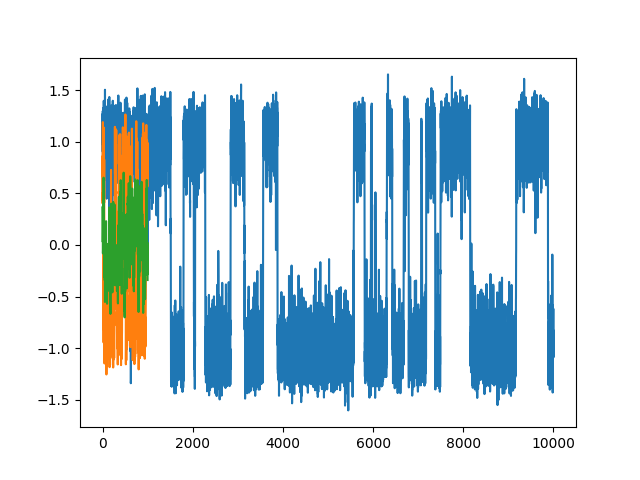

In [17]:
fig, ax = plt.subplots(1,1)
ax.plot(resBroken['meas'])
ax.plot(resBroken2['meas'])
ax.plot(resSymm['meas'])
plt.show()

# Sampling using flows

Let's concoct a synthetic example of a flow, to see how it can result in sampling interesting distributions. Prior distribution
$$
r(x_0, x_1) = \frac{1}{2\pi} \exp(-(x_0^2 + x_1^2)/2)
$$
and flow $\dot{x} = b(x)$ to be integrated over $t \in [0,1]$. For this example, we use a velocity designed to create a double-peaked distribution
$$
b(x) = \begin{pmatrix}
x_0 e^{-x_0^2/2} \\ - x_1
\end{pmatrix}
$$
for which $\nabla \cdot b = (1 - x_0^2) e^{-x_0^2/2} - 1$.

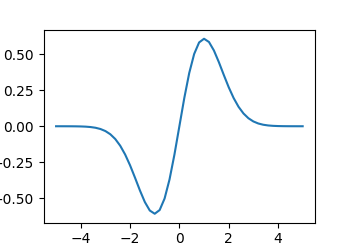

In [23]:
x0 = np.linspace(-5, 5, num=51)
b0 = x0 * np.exp(-x0**2 / 2)
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
ax.plot(x0, b0)
plt.show()

In [35]:
class ToyVelocity:
    def value(self, x):
        x0, x1 = x[0], x[1]
        return torch.stack([
            x0 * torch.exp(-x0**2 / 2),
            -x1
        ])
    def div(self, x):
        x0, x1 = x[0], x[1]
        return (1 - x0**2) * torch.exp(-x0**2 / 2) - 1

def flow(x, velocity, *, n_step, tf=1.0, inverse=False):
    logJ = torch.tensor(0.0)
    dt = tf / n_step
    if inverse:
        dt *= -1
    for i in range(n_step):
        x = x + dt * velocity.value(x)
        logJ = logJ + dt * velocity.div(x)
    return x, logJ

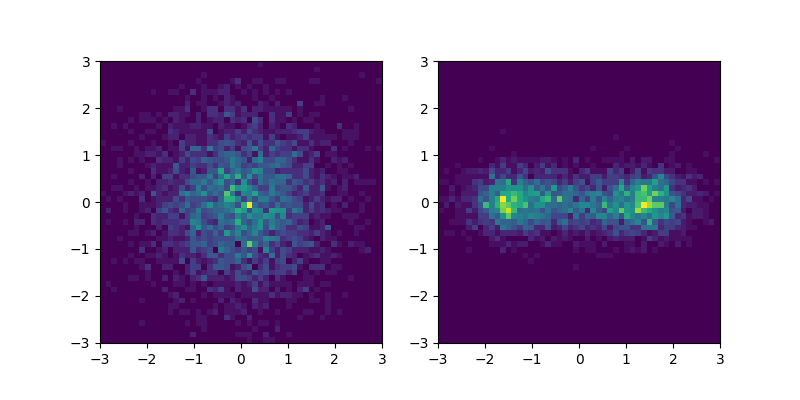

In [42]:
xr = torch.randn((4096, 2))
velocity = ToyVelocity()
flow_batch = torch.func.vmap(flow, in_dims=(0, None))
xp, logJ = flow_batch(xr, velocity, n_step=100, tf=1.0)
fig, axes = plt.subplots(1, 2, figsize=(8,4))
xr = xr.numpy()
xp = xp.numpy()
axes[0].hist2d(xr[:,0], xr[:,1], bins=np.linspace(-3, 3, 51))
axes[1].hist2d(xp[:,0], xp[:,1], bins=np.linspace(-3, 3, 51))
for ax in axes:
    ax.set_aspect(1.0)
plt.show()
# x2, logJ2 = flow_batch(xp.clone(), velocity, n_step=100, tf=1.0, inverse=True)
# print(xp)
# print(x2)

Change of measure from flow $x = f(x_r)$ is given by
$$
\log{q}(x) = \log{r}(x_r) - \log{J}_f
$$
To remember the sign: **stretching** ($\log{J}_f > 0$) **reduces** the density.

In [ ]:
# Left as an exercise due to time!
def eval_logq(x, tf):
    pass